# [Deep Q-Learning (DQN) by Samina Amin](https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae)

## 載入套件

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

## 載入木棒台車遊戲

In [2]:
env = gym.make("CartPole-v1")

## 定義神經網路模型

In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

## 超參數設定

In [4]:
learning_rate = 0.001 # 學習率
gamma = 0.99  # 折扣率
epsilon = 1.0 # ε-greedy的ε
epsilon_min = 0.01 # ε 最小值
epsilon_decay = 0.995 # 衰退率
batch_size = 64 # 訓練批量
target_update_freq = 1000  # 模型權重複製頻率
memory_size = 10000 # 緩衝區大小
episodes = 1000 # 回合數

## 建立策略(policy)及目標(target)2個Q-network

In [5]:
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

## 建立 Experience Replay Memory

In [6]:
memory = deque(maxlen=memory_size)

## 定義行動選擇的函數

In [7]:
# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit

## 定義模型訓練的函數

In [8]:
def optimize_model():
    if len(memory) < batch_size:
        return

    # 自Experience Replay Memory抽樣
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(np.array(state_batch))
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(np.array(next_state_batch))
    done_batch = torch.FloatTensor(done_batch)

    # 計算 Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # 計算  target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    # 模型訓練
    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## 模型訓練

In [9]:
import datetime

rewards_per_episode = []
steps_done = 0
start = datetime.datetime.now()
for episode in range(episodes):
    state, info = env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        # 使用 Policy network 選擇行動
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # 將交易存入緩衝區
        memory.append((state, action, reward, next_state, done))
        
        # 更新狀態
        state = next_state
        episode_reward += reward
        
        # 模型訓練
        optimize_model()

        # 每隔一段時間更新 Target network
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        steps_done += 1

    # ε-greedy的ε(epsilon)逐漸衰退，趨近greedy
    epsilon = max(epsilon_min, epsilon_decay * epsilon)    
    rewards_per_episode.append(episode_reward)
print(datetime.datetime.now()-start)    

0:04:02.498146


## 繪圖

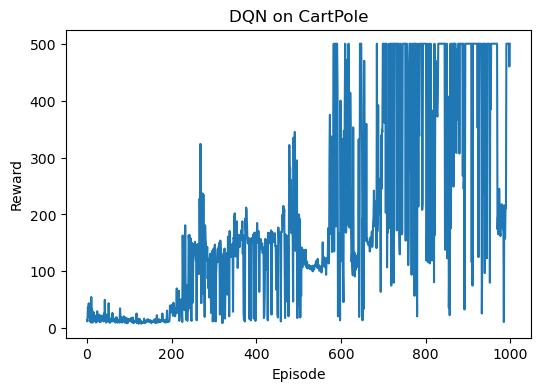

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on CartPole')
plt.show()

## 測試行動策略

In [13]:
def play_episodes(environment, n_episodes):
    wins = 0
    acc_reward = 0
    for episode in range(n_episodes):
        total_reward = 0
        done = False
        state, info = environment.reset()
        while not done:
            # Select best action to perform in a current state
            action = select_action(state, epsilon)
            # Perform an action an observe how environment acted in response
            next_state, reward, terminated, truncated, info = environment.step(action)
            done = terminated or truncated
            # Summarize total reward
            total_reward += reward
            acc_reward += reward
            # Update current state
            state = next_state
            # Calculate number of wins over episodes
            if done and total_reward >= 500:
                wins += 1
    average_reward = acc_reward / n_episodes
    return wins, acc_reward, average_reward

# 測試 1000 回合
n_episodes = 1000
wins, total_reward, average_reward = play_episodes(env, n_episodes)
print(f'number of wins over {n_episodes} episodes = {wins}')
print(f'average reward over {n_episodes} episodes = {average_reward} \n\n')

number of wins over 1000 episodes = 992
average reward over 1000 episodes = 497.704 


